<a href="https://colab.research.google.com/github/zzuupp/Object_Detection-Segmentation/blob/main/pytorch-objdet/Pytorch_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection 구현

In [1]:
import numpy as np
import pandas as pd
import os
import sys

In [2]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
from torch.utils.tensorboard import SummaryWriter

In [4]:
Aqua_data_train_url  = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco/train'
Aqua_data_valid_url = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco/valid'
Aqua_data_test_url = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco/test'

#### 변환 함수 생성.

In [5]:
def get_transform(train = False):
    if train :
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p = 0.3), # 30% 확률로 좌우 뒤집기.
            A.VerticalFlip(p = 0.3),   # 30% 확률로 위아래 뒤집기.
            A.RandomBrightnessContrast(p = 0.1), # 10% 확률로 밝기/대비 무작위 변화.
            A.ColorJitter(p = 0.1), # 10% 확률로 색상/채도/명도 변화
            ToTensorV2() # NumPy => PyTorch Tensor 변환
        ], bbox_params = A.BboxParams(format = 'coco'))  #객체 탐지는 바운딩박스도 함께 변환해야함.

    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params = A.BboxParams(format = 'coco'))

    return transform

In [6]:
def collate_fn(batch):
    """
    batch: 학생별 데이터 : [ ("철수", 15), ("영희", 16), ("민수", 14) ]

    zip(*batch): 필드별 데이터 : [ ("철수", "영희", "민수"), (15, 16, 14) ]
    """
    return tuple(zip(*batch))

#### 데이터셋 관련 함수

In [21]:

# datasets.VisionDataset: 이미지 데이터셋을 만들 때 공통적으로 필요한 기능(루트 경로, transform, target_transform, 데이터 길이, 인덱싱 등)을 기본 제공하는 추상 클래스
class AquariumDetection(datasets.VisionDataset):

    def __init__(self, root, split = 'train', transform = None, target_transform = None, transforms = None):
        # 상속
        super().__init__(root, transforms, transform, target_transform)

        # 변수 지정
        self.split = split
        # 경로 지정
        self.coco = COCO(os.path.join(root, split, '_annotations.coco.json'))

        # 어노테이션 파일의 존재하는키값 가져오기.
        self.ids = list(sorted(self.coco.imgs.keys()))

        # 어노테이션 파일에 없는건 제외하기 위함인거 같음.
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    # id : int
    def _load_image(self, id : int):

        """

        self.coco.imgs = {
            1: {"file_name": "0001.jpg", "height": 480, "width": 640},
            2: {"file_name": "0002.jpg", "height": 720, "width": 1280}
        }

        이런식인데, self.coco.loadImgs(1) 을 해버리면 (id = 숫자),
        [{'id': 1, 'file_name': '0001.jpg', 'height': 480, 'width': 640}]
        와 같이 해당 형태의 정보를 리스트 형태로 반환함.
        그래서 리스트 벗기기 위해서 [0]사용.

        """

        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):

        """
        COCO 어노테이션 JSON은 보통 다음의 구조를 지닌다.
        {
        "images": [
            {"id": 1, "file_name": "0001.jpg"},
            {"id": 2, "file_name": "0002.jpg"}
        ],

        "annotations": [
            {"id": 11, "image_id": 1, "category_id": 3, "bbox": [20, 35, 50, 60]},
            {"id": 12, "image_id": 1, "category_id": 1, "bbox": [200, 250, 60, 80]},
            {"id": 13, "image_id": 2, "category_id": 2, "bbox": [15, 25, 70, 90]}
        ],

        "categories": [
            {"id": 1, "name": "fish"},
            {"id": 2, "name": "shark"},
            {"id": 3, "name": "jellyfish"}
        ]
        }


        pycocotools.COCO로 위 JSON 읽을 때,
        self.coco.anns = {
                            11: {"id": 11, "image_id": 1, "category_id": 3, "bbox": [20, 35, 50, 60]},
                            12: {"id": 12, "image_id": 1, "category_id": 1, "bbox": [200, 250, 60, 80]},
                            13: {"id": 13, "image_id": 2, "category_id": 2, "bbox": [15, 25, 70, 90]},
                         }


        예를 들어서, 이미지 1의 어노테이션들을 찾고 싶을 때,

        ann_ids = self.coco.getAnnIds(imgIds=1) / print(ann_ids)
        print(ann_ids) -> [11, 12]
        * 이건 단순히 “image_id가 1인 어노테이션들의 id 리스트”예요.
        * 즉, 이미지 1에는 annotation 11, 12가 존재한다는 뜻.


        이후, self.coco.loadAnns(ann_ids) 호출하면,  -> anns = self.coco.loadAnns([11, 12])

        [
        {"id": 11, "image_id": 1, "category_id": 3, "bbox": [20, 35, 50, 60]},
        {"id": 12, "image_id": 1, "category_id": 1, "bbox": [200, 250, 60, 80]}
        ]

        loadAnns()는 전달받은 id 리스트를 이용해서
        self.coco.anns 딕셔너리 안에서 해당 id에 해당하는 데이터를 찾아서 리스트 형태로 반환합니다.

        """
        # getAnnIds() → 어떤 annotation들이 있는지 id만 알아냄
        # loadAnns() → 그 id들로 실제 내용(박스 좌표, 클래스 등)을 조회
        return self.coco.loadAnns(self.coco.getAnnIds(id))


    # 객체를 리스트처럼 인덱싱할 수 있게 : __getitem__
    # 즉, 원하는 인덱스에 해당하는 데이터(이미지, 라벨) 반환 / 리스트처럼 인덱스로 데이터를 꺼내는 법 정의
    def __getitem__(self,index):

        # ids : 어노테이션이 있는것들만 추리게 됨.
        id = self.ids[index]


        # 내부에서 접근하게 설정한 코드
        image = self._load_image(id)
        target= self._load_target(id) #이미지에 존재하는 어노테이션의 모든정보 조회 (박스 좌표, 클래스 등)
        target = copy.deepcopy(self._load_target(id)) # 통복사 ('진짜'가 변경되지 않도록)

        # target = 어노테이션파일, 여기에서 boundingbox, id만 빼서 저장.
        boxes = [t['bbox'] + [t['category_id']] for t in target]


        # transforms를 적용한 경우와 아닌 경우.
        if self.transforms is not None:
            # 앞에서 본 이미지 변환.
            transformed = self.transforms(image = image, bboxes = boxes)


        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        # ❗️ PyTorch / Albumentations / 모델들은 XYXY 형식 (xmin, ymin, xmax, ymax)을 원합니다.
        # coco box는 bbox = [x_min, y_min, width, height] 와 같이 정의되어 있음.
        '''
        그래서 x_min은 항상 그 박스에서 가장 왼쪽에 있는 x좌표
        → 즉, x좌표 중 최소값

        y_min은 항상 그 박스에서 가장 위쪽에 있는 y좌표
        → 즉, y좌표 중 최소값

        '''

        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax  = ymin + box[3]

            # 왼쪽 위 : xmin,y_min  //  오른쪽 아래 : xmax, ymax
            new_boxes.append([xmin, ymin, xmax, ymax])


        boxes = torch.tensor(new_boxes, dtype = torch.float32)

        # 변환값을 담을 리스트 생성.
        targ = {}
        targ['boxes'] = boxes


        # PyTorch의 객체 탐지 모델들(Faster R-CNN, SSD, YOLO 등)은 라벨(label) 값을 정수형(LongTensor) 으로 기대
        # 즉, float(소수형)이나 bool 타입이면 학습 시 에러가 나요.
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype = torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:, 0])

        # iscrowd : 바운딩 박스가 개별 객체인지, 여러 객체가 뭉친 덩어리인지 (0: 일반 객체, 1 군집 객체)
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype = torch.int64)

        # 이미지 픽셀값 정규화 0~255
        return image.div(255), targ

    # 데이터셋의 전체 크기 반환(이미지 개수)
    def __len__(self):
        return len(self.ids)


## 데이터 전처리 및 확인.


In [23]:
dataset_path = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco'

# coco 형식의 어노테이션 json 파일 읽기.
coco = COCO(os.path.join(dataset_path, 'train','_annotations.coco.json'))

# 카테고리 확인.
categories = coco.cats

# 개수
n_classes = len(categories.keys())

# 확인
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [24]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [25]:
# train data
train_dataset = AquariumDetection(root = dataset_path, transforms = get_transform(train = True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


* 샘플 데이터 확인.

In [30]:
# 이미지 1개 임의로 설정.
sample = train_dataset[2]

# 첨고 : 안에 담겨 있는 정보 확인.
sample

(tensor([[[0.6667, 0.6745, 0.6902,  ..., 0.9569, 1.0000, 1.0000],
          [0.6941, 0.6902, 0.6824,  ..., 1.0000, 1.0000, 1.0000],
          [0.6902, 0.6824, 0.6784,  ..., 0.9961, 1.0000, 1.0000],
          ...,
          [0.2431, 0.2431, 0.2431,  ..., 0.2157, 0.2118, 0.2078],
          [0.2275, 0.2353, 0.2353,  ..., 0.2157, 0.2118, 0.2118],
          [0.2275, 0.2353, 0.2392,  ..., 0.2196, 0.2157, 0.2118]],
 
         [[0.6118, 0.6235, 0.6353,  ..., 0.8353, 0.8902, 0.9569],
          [0.6392, 0.6353, 0.6314,  ..., 0.9216, 0.9647, 1.0000],
          [0.6353, 0.6314, 0.6275,  ..., 0.8863, 0.8980, 0.9059],
          ...,
          [0.4078, 0.4078, 0.4078,  ..., 0.3137, 0.3098, 0.3059],
          [0.3961, 0.4000, 0.4000,  ..., 0.3176, 0.3098, 0.3098],
          [0.3961, 0.4000, 0.4039,  ..., 0.3176, 0.3137, 0.3098]],
 
         [[0.6588, 0.6667, 0.6784,  ..., 0.7882, 0.8392, 0.9059],
          [0.6824, 0.6784, 0.6745,  ..., 0.8706, 0.9176, 0.9608],
          [0.6784, 0.6745, 0.6706,  ...,

/tmp/ipython-input-3974730949.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(sample[0] * 255, dtype = torch.uint8)


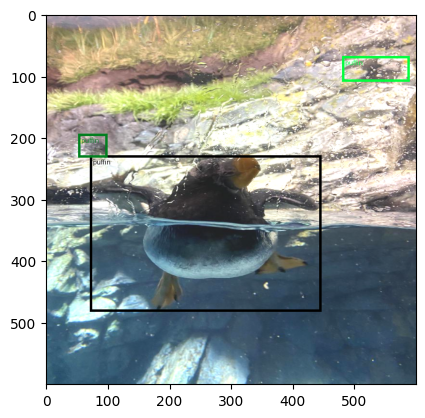

In [36]:
# 이미지 확인.
# 정규화(255)된 이미지 파일을 역정규화 하기. ( * 255)
img_int = torch.tensor(sample[0] * 255, dtype = torch.uint8)

# * draw_bounding_boxes() : 이미지(torch.Tensor 형태)일 때, 해당 이미지 위에 바운딩 박스를 그려주는 시각화.
plt.imshow(
    draw_bounding_boxes(
                        img_int,
                        sample[1]['boxes'],
                         [classes[i] for i in sample[1]['labels']],
                        width = 4).permute(1, 2, 0))

In [37]:
#### pytorch 에서 제공하는 모델 다운받아 사용.
# 파이토치는 모델만 제공함, 나머지는 설정해야 함.



model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)



# in_features : 분류모델 헤드에 들어가는 입력피처수 설정.
# why? 내 데이터 클래스 수에 맞게 출력층을 교체해야 하기 때문.
'''
roi_heads	Region-of-Interest 헤드: 감지된 후보 영역(ROI)을 분류·박스 회귀하는 부분
box_predictor	ROI Heads 안의 최종 예측기(classifier + regressor)
cls_score	클래스 확률을 예측하는 nn.Linear 층
in_features	cls_score 층에 들어가는 입력 벡터 차원 수
'''
in_features = model.roi_heads.box_predictor.cls_score.in_features

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:01<00:00, 73.0MB/s]
